# Reaction-diffusion  

\begin{align*}
u_t &= 0.1\nabla^2 u + \lambda(A)u - \omega(A)v\\
v_t &= 0.1\nabla^2 v + \omega(A)u + \lambda(A)v\\
A^2 &= u^2 + v^2,\, \omega(A) = -\beta A^2, \lambda(A) = 1-A^2
\end{align*}

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('reaction_diffusion.mat')

<ipython-input-3-6dcf9a529aec>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(xx,yy,U[:,:,10],cmap='viridis')
<ipython-input-3-6dcf9a529aec>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(xx,yy,V[:,:,10],cmap='viridis')


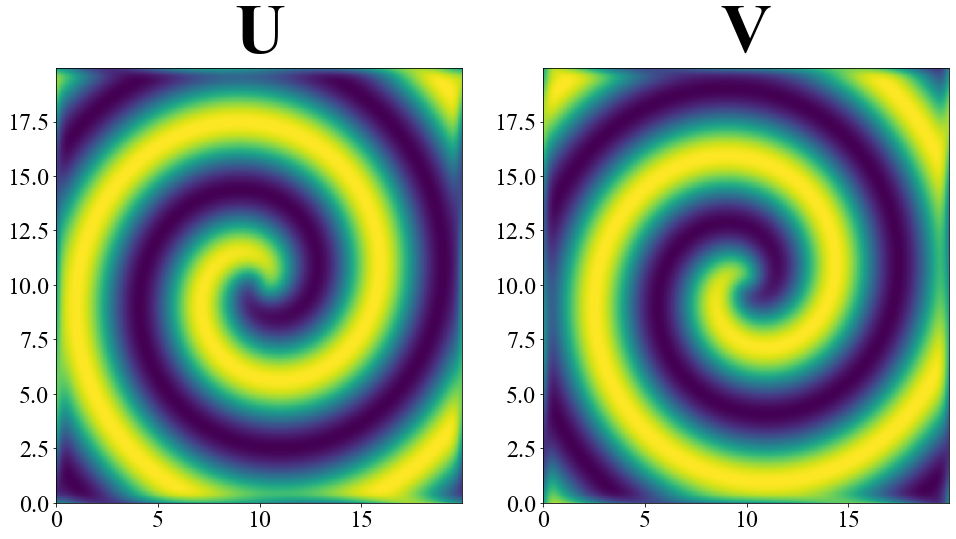

In [3]:
t = data['t'][:,0]
x = data['x'][0,:]
y = data['y'][0,:]
U = data['u']
V = data['v']

n = len(x) 
steps = len(t)
dx = x[2]-x[1]
dy = y[2]-y[1]
dt = t[2]-t[1]
plt.rcParams['axes.unicode_minus']=False 
pylab.rcParams['figure.figsize'] = (16,8)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)

ax = plt.subplot(1,2,1)
pcolor(xx,yy,U[:,:,10],cmap='viridis')
title('U', fontsize = 70,fontproperties="Times New Roman",weight='bold')
xlabel('')
ylabel('')
#plt.axis('off')
plt.tick_params(labelsize=24)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
ax=plt.subplot(1,2,2)
pcolor(xx,yy,V[:,:,10],cmap='viridis')
plt.tick_params(labelsize=24)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
title('V', fontsize = 70,fontproperties="Times New Roman",weight='bold')
xlabel('')
ylabel('')
plt.savefig("./RD.jpg",dpi=2000) 

## Sample data

In [4]:
numpy.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 30
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    y = np.random.choice(np.arange(boundary,n-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,6*t+10]
        count = count + 1 

## Construct $\Theta (U)$ and compute $U_t$

In [5]:
def PolyDiffPoint(u, x, deg = 3, diff = 1, index = None):
    
    """
    Same as above but now just looking at a single point

    u = values of some function
    x = x-coordinates where values are known
    deg = degree of polynomial to use
    diff = maximum order derivative we want
    """
    
    n = len(x)
    if index == None: index = (n-1)//2

    # Fit to a Chebyshev polynomial
    # better conditioned than normal polynomials
    poly = np.polynomial.chebyshev.Chebyshev.fit(x,u,deg)
    
    # Take derivatives
    derivatives = []
    for d in range(1,diff+1):
        derivatives.append(poly.deriv(m=d)(x[index]))
        
    return derivatives

In [6]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
ut = np.zeros((num_points,1))
vt = np.zeros((num_points,1))
ux = np.zeros((num_points,1))
uy = np.zeros((num_points,1))
uxx = np.zeros((num_points,1))
uxy = np.zeros((num_points,1))
uyy = np.zeros((num_points,1))
vx = np.zeros((num_points,1))
vy = np.zeros((num_points,1))
vxx = np.zeros((num_points,1))
vxy = np.zeros((num_points,1))
vyy = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    
    # value of function
    u[p] = U[x,y,t]
    v[p] = V[x,y,t]
    
    # time derivatives
    ut[p] = PolyDiffPoint(U[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    vt[p] = PolyDiffPoint(V[x,y,t-(Nt-1)//2:t+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)[0]
    
    # spatial derivatives
    ux_diff = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    uy_diff = PolyDiffPoint(U[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    vx_diff = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y,t], np.arange(N)*dx, deg, 2)
    vy_diff = PolyDiffPoint(V[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    ux_diff_yp = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    ux_diff_ym = PolyDiffPoint(U[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    vx_diff_yp = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y+1,t], np.arange(N)*dx, deg, 2)
    vx_diff_ym = PolyDiffPoint(V[x-(N-1)//2:x+(N+1)//2,y-1,t], np.arange(N)*dx, deg, 2)
    
    ux[p] = ux_diff[0]
    uy[p] = uy_diff[0]
    uxx[p] = ux_diff[1]
    uxy[p] = (ux_diff_yp[0]-ux_diff_ym[0])/(2*dy)
    uyy[p] = uy_diff[1]
    
    vx[p] = vx_diff[0]
    vy[p] = vy_diff[0]
    vxx[p] = vx_diff[1]
    vxy[p] = (vx_diff_yp[0]-vx_diff_ym[0])/(2*dy)
    vyy[p] = vy_diff[1]

In [7]:
def build_Theta(data, derivatives, derivatives_description, P, data_description = None):
    """
    input:
        data: column 0 is U, and columns 1:end are Q
        derivatives: a bunch of derivatives of U and maybe Q, should start with a column of ones
        derivatives_description: description of what derivatives have been passed in
        P: max power of polynomial function of U to be included in Theta

    returns:
        Theta = Theta(U,Q)
        descr = description of what all the columns in Theta are
    """
    
    n,d = data.shape
    m, d2 = derivatives.shape
    if n != m: raise Exception('dimension error')
    if data_description is not None: 
        if len(data_description) != d: raise Exception('data descrption error')
    
    # Create a list of all polynomials in d variables up to degree P
    rhs_functions = {}
    f = lambda x, y : np.prod(np.power(list(x), list(y)))
    powers = []            
    for p in range(1,P+1):
            size = d + p - 1
            for indices in itertools.combinations(range(size), d-1):
                starts = [0] + [index+1 for index in indices]
                stops = indices + (size,)
                powers.append(tuple(map(operator.sub, stops, starts)))
    for power in powers: rhs_functions[power] = [lambda x, y = power: f(x,y), power]

    # First column of Theta is just ones.
    Theta = np.ones((n,1), dtype=np.complex64)
    descr = ['']
    
    # Add the derivaitves onto Theta
    for D in range(1,derivatives.shape[1]):
        Theta = np.hstack([Theta, derivatives[:,D].reshape(n,1)])
        descr.append(derivatives_description[D])
        
    # Add on derivatives times polynomials
    for D in range(derivatives.shape[1]):
        for k in rhs_functions.keys():
            func = rhs_functions[k][0]
            new_column = np.zeros((n,1), dtype=np.complex64)
            for i in range(n):
                new_column[i] = func(data[i,:])*derivatives[i,D]
            Theta = np.hstack([Theta, new_column])
            if data_description is None: descr.append(str(rhs_functions[k][1]) + derivatives_description[D])
            else:
                function_description = ''
                for j in range(d):
                    if rhs_functions[k][1][j] != 0:
                        if rhs_functions[k][1][j] == 1:
                            function_description = function_description + data_description[j]
                        else:
                            function_description = function_description + data_description[j] + '^' + str(rhs_functions[k][1][j])
                descr.append(function_description + derivatives_description[D])

    return Theta, descr

In [9]:
import operator
X_data = np.hstack([u,v])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u','v'])
['1'] + description[1:]

['1',
 'u_{x}',
 'u_{y}',
 'u_{xx}',
 'u_{xy}',
 'u_{yy}',
 'v_{x}',
 'v_{y}',
 'v_{xx}',
 'v_{xy}',
 'v_{yy}',
 'v',
 'u',
 'v^2',
 'uv',
 'u^2',
 'v^3',
 'uv^2',
 'u^2v',
 'u^3',
 'vu_{x}',
 'uu_{x}',
 'v^2u_{x}',
 'uvu_{x}',
 'u^2u_{x}',
 'v^3u_{x}',
 'uv^2u_{x}',
 'u^2vu_{x}',
 'u^3u_{x}',
 'vu_{y}',
 'uu_{y}',
 'v^2u_{y}',
 'uvu_{y}',
 'u^2u_{y}',
 'v^3u_{y}',
 'uv^2u_{y}',
 'u^2vu_{y}',
 'u^3u_{y}',
 'vu_{xx}',
 'uu_{xx}',
 'v^2u_{xx}',
 'uvu_{xx}',
 'u^2u_{xx}',
 'v^3u_{xx}',
 'uv^2u_{xx}',
 'u^2vu_{xx}',
 'u^3u_{xx}',
 'vu_{xy}',
 'uu_{xy}',
 'v^2u_{xy}',
 'uvu_{xy}',
 'u^2u_{xy}',
 'v^3u_{xy}',
 'uv^2u_{xy}',
 'u^2vu_{xy}',
 'u^3u_{xy}',
 'vu_{yy}',
 'uu_{yy}',
 'v^2u_{yy}',
 'uvu_{yy}',
 'u^2u_{yy}',
 'v^3u_{yy}',
 'uv^2u_{yy}',
 'u^2vu_{yy}',
 'u^3u_{yy}',
 'vv_{x}',
 'uv_{x}',
 'v^2v_{x}',
 'uvv_{x}',
 'u^2v_{x}',
 'v^3v_{x}',
 'uv^2v_{x}',
 'u^2vv_{x}',
 'u^3v_{x}',
 'vv_{y}',
 'uv_{y}',
 'v^2v_{y}',
 'uvv_{y}',
 'u^2v_{y}',
 'v^3v_{y}',
 'uv^2v_{y}',
 'u^2vv_{y}',
 'u^3v_

In [10]:
sio.savemat('RD_data.mat',{'Ut':ut,'Vt':vt,'R':X})